In [1]:
from tick.hawkes import HawkesExpKern, SimuHawkesMulti, SimuHawkesSumExpKernels, HawkesSumExpKern
from tick.plot import plot_hawkes_kernels
import numpy as np
import pandas as pd

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
data = pd.read_csv("data.csv", index_col=0)
data["Time"] = data["Time"]-data["Time"].min()
print("Data shape : {}".format(data.shape))
data.head()

Data shape : (8642, 6)


,Magnitude,Place,Time,Longitude,Latitude,Depth
0,4.8,"108 km ESE of Tatsugō, Japan",189217632064,130.6658,28.1762,24.420
1,4.3,"116 km SE of Kuril’sk, Russia",189180540345,148.9932,44.5454,35.000
2,4.2,"Maug Islands region, Northern Mariana Islands",189175914031,145.6748,20.0351,123.949
3,4.2,"64 km NE of Otrada, Russia",189165625522,146.4847,44.4452,155.813
4,4.4,"108 km SE of Kuril’sk, Russia",189164722302,148.9343,44.6077,35.000


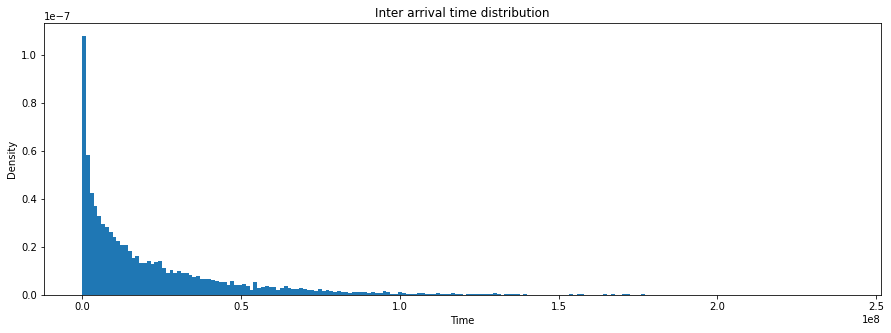

In [3]:
times = data['Time'].values

plt.figure(figsize=(15,5))
delta_times = times[:-1] - times[1:]
mean_delta = delta_times.mean()
h = plt.hist(delta_times, bins=200, density=True)
plt.title("Inter arrival time distribution")
plt.xlabel("Time")
plt.ylabel("Density")
plt.show()

<ipython-input-4-74ebf30f5977>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(19.5042, 50.3266)

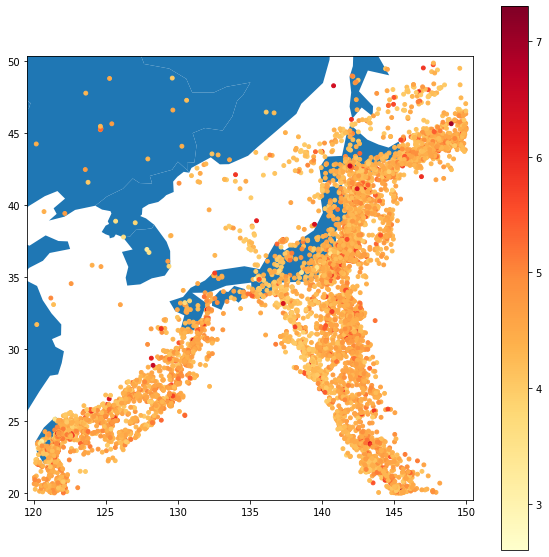

In [4]:
# Assuming 'data' is a DataFrame that includes 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = GeoDataFrame(data, geometry=geometry)

# Load a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calculate bounds of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Plotting
ax = world.plot(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', column='Magnitude', markersize=15, cmap='YlOrRd', legend=True)

# Adjust the plotting range to center on the scatter
# You might want to add a small margin around the edges for better visualization
margin = 0.5  # Adjust this value based on your preference
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

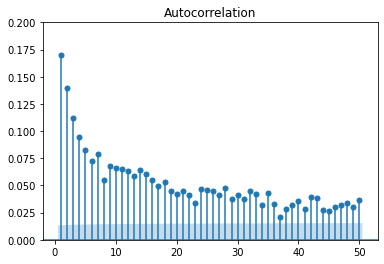

In [5]:
events_times = np.sort(data["Time"])

# Assuming `event_times` is a sorted NumPy array of event times
# Convert event times to counts per time bin for ACF analysis
time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = np.histogram(events_times, bins=time_bins)[0]

# Plot the ACF of event counts
plot_acf(event_counts, lags=50, alpha=0.01, zero=False) 
plt.ylim(0, 0.2)
plt.show()

In [6]:
def classify_magnitude(magnitude):
    if magnitude < 2:
        return 'tiny'
    elif 2 <= magnitude < 3:
        return 'very small'
    elif 3 <= magnitude < 4:
        return 'small'
    elif 4 <= magnitude < 5:
        return 'moderate'
    elif 5 <= magnitude < 6:
        return 'strong'
    else:
        return 'very strong'
    
data['Classification'] = data['Magnitude'].apply(classify_magnitude)

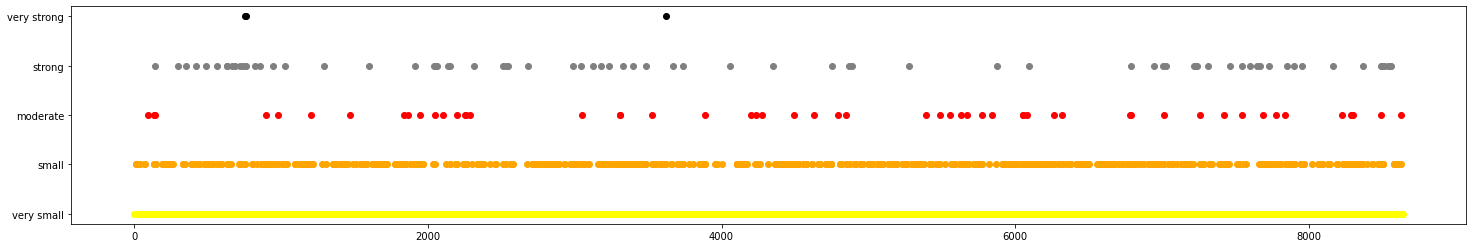

In [7]:
data["Time"] = data["Time"]/mean_delta
list_times = [data[data['Classification']==c]['Time'].values.astype(np.float64) for c in data['Classification'].unique()]

time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = [np.histogram(list_times[c], bins=time_bins)[0] for c in range(data['Classification'].nunique())]

plt.figure(figsize=(25,4))
colors = ['yellow', 'orange', 'red', 'grey', 'black']
for k in range(len(list_times)):
    plt.scatter(list_times[k], [k]*len(list_times[k]), color=colors[k])

# Set y-axis labels
classification_labels = ['very small', 'small', 'moderate', 'strong', 'very strong']
plt.yticks(range(len(classification_labels)), classification_labels)

plt.show()

In [8]:
events = [list_times]
decays = np.array([1.]*len(data['Classification']))

hawkes_exp_kernels = HawkesSumExpKern(decays=decays, penalty='elasticnet',elastic_net_ratio=0.8)
hawkes_exp_kernels.fit(events)

: 

In [ ]:
generated = SimuHawkesMulti(hawkes_exp_kernels, n_simulations=3000) #Generate 3000 new datapoints from the fitted Hawkes process